# One Pixel Attack Tutorial

![](images/horse.png "I'm a normal horse, nothing suspicious here") ![](images/horse-attack.png "I'm an attack horse, grr")

### Imports

In [ ]:
# Python Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from scipy.optimize import differential_evolution
from scipy.stats import truncnorm
from IPython.display import clear_output

In [2]:
# Custom Networks
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet

from helper import get_class_names, plot_image

In [3]:
matplotlib.style.use('ggplot')

### Load Data

Load the Cifar10 dataset and all necessary metadata.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# Obtain the names of the 10 classes in cifar10
class_names = get_class_names()
print(class_names)

Decoding file: data/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Load Models

Load various pretrained Neural Network models in the `networks/models` directory. There are more networks available, but must be trained before testing them here.

Keras will need to also download the Cifar10 dataset if it is not cached locally already.

In [6]:
lecun_net = LecunNet()
pure_cnn = PureCnn()
net_in_net = NetworkInNetwork()
resnet = ResNet()
densenet = DenseNet()
wide_resnet = WideResNet()

models = [lecun_net, pure_cnn, net_in_net, resnet, densenet, wide_resnet]

Successfully loaded lecun_net
Successfully loaded pure_cnn
Successfully loaded net_in_net
Successfully loaded resnet
Successfully loaded densenet
Successfully loaded wide_resnet


### Calculate Model Accuracies

In [7]:
network_stats = pd.DataFrame(columns=['name', 'accuracy', 'param_count'], data=[
    [model.name, model.acc, model.param_count]
    for model in models])

In [8]:
network_stats

,name,accuracy,param_count
0,lecun_net,0.7488,62006
1,pure_cnn,0.8877,1369738
2,net_in_net,0.9074,972658
3,resnet,0.9231,470218
4,densenet,0.9467,850606
5,wide_resnet,0.9534,11318026


### Image Perturbation

In [9]:
def perturb_image(x, img):
    img = np.copy(img)
    pixels = np.split(x.astype(int), len(x) // 5)
    for x in pixels:
        x_pos, y_pos, rgb = *x[:2], x[2:]
        img[x_pos][y_pos] = rgb
    return img

In [10]:
def predict_untargeted(x, *args):
    img, correct_class, model = args
    img_perturbed = perturb_image(x, img)
    prediction = model.predict(img_perturbed)
    return prediction[correct_class]

In [11]:
def predict_targeted(x, *args):
    img, target_class, model = args
    img_perturbed = perturb_image(x, img)
    prediction = model.predict(img_perturbed)
    return 1 - prediction[target_class]

### Untargeted Attack

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to minimize the probability of the correct classification category and maximize the sum of the probabilities of all other categories.

In [12]:
def attack_untargeted_iteration(img, model, pixel_count=1, iterations=30,
                                population=100, mutation=0.5, recombination=0.7, 
                                stop_threshold=-0.01, callback=None):
    print('Attacking image', img)
    
    args = x_test[img], y_test[img], model
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    attack = predict_untargeted

    cb = None if callback == None else lambda x,convergence: callback(x, convergence, args)
    disp = callback == None
    
    res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=1, atol=stop_threshold, disp=disp, callback=cb)

    attack_image = perturb_image(res.x, x_test[img])
    predicted_probs = model.predict(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class != actual_class

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [img, actual_class, predicted_class, success, predicted_probs, attack_image]

In [13]:
def untargeted_callback(x, convergence, args):
    img, correct_class, model = args
    correct_class = correct_class[0]
    img_perturbed = perturb_image(x, img)
    confidence = model.predict(img_perturbed)
    prediction = np.argmax(confidence)
    print('Confidence:', confidence[correct_class])
    if (prediction != correct_class):
        return True # Do it this way because returning it directly will prevent early halting

Attacking image 99
Confidence: 0.9932366
Confidence: 0.9932366
Confidence: 0.95751077
Confidence: 0.94805044
Confidence: 0.9150485
Confidence: 0.49535528


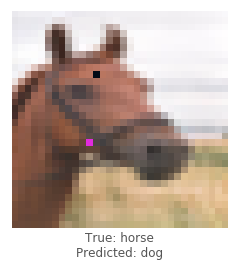

In [15]:
_ = attack_untargeted_iteration(99, wide_resnet, pixel_count=2, callback=untargeted_callback)

In [ ]:
# def attack_iteration(img, model, target=None, pixel_count=1, iterations=30,
#                                 population=100, mutation=0.5, recombination=0.7, 
#                                 stop_threshold=-0.01, callback=None):
#     info = 'Attacking image ' + str(img)
#     info += ' with target ', target, class_names[target] if target else ''
#     print(info)
    
#     attack = predict_targeted if target else predict_untargeted
#     args = x_test[img], target, model if target else x_test[img], y_test[img], model
#     bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
#     cb = None if callback == None else lambda x,convergence: callback(x, convergence, args)
#     disp = callback == None
    
#     res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=1, atol=stop_threshold, disp=disp, callback=cb)

#     attack_image = perturb_image(res.x, x_test[img])
#     predicted_probs = model.predict(attack_image)
#     predicted_class = np.argmax(predicted_probs)
#     actual_class = y_test[img][0]
#     success = predicted_class != actual_class

#     plot_image(attack_image, actual_class, class_names, predicted_class)

#     return [img, actual_class, predicted_class, success, predicted_probs, attack_image]

In [ ]:
def attack_untargeted(model, pixel_count=1, sample_count=100, iterations=30,
                      population=100, mutation=0.5, recombination=1, 
                      stop_threshold=-0.01, callback=untargeted_callback):
    print('Targeting model', model.name)
    
    samples = np.random.choice(len(x_test), sample_count)
    
    results = []
    for i,img in enumerate(samples):
        print('Sample', i)
        result = attack_untargeted_iteration(
            img, model, pixel_count, iterations,
            population, mutation, recombination, 
            stop_threshold, callback)
        results.append(result)
        print()
    
    return pd.DataFrame(
        data=results,
        columns=['image_index', 'true_class', 'predicted_class', 'success', 'predicted_probs', 'attack_image']
    )

In [ ]:
untargeted_results = attack_untargeted(resnet)

In [ ]:
untargeted_results

### Targeted Attack

In [16]:
def attack_targeted_iteration(img, model, target, pixel_count=1, iterations=30,
                              population=100, mutation=0.5, recombination=0.7, 
                              stop_threshold=-0.01, callback=None):
    print('Attacking image', img, 'with target', target, class_names[target])
    
    args = x_test[img], target, model
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    attack = predict_targeted

    cb = None if callback == None else lambda x,convergence: callback(x, convergence, args)
    disp = callback == None
    
    res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=1, atol=stop_threshold, disp=disp, callback=cb)

    attack_image = perturb_image(res.x, x_test[img])
    predicted_probs = model.predict(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class == target

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [img, actual_class, predicted_class, success, predicted_probs, attack_image]

In [22]:
def targeted_callback(x, convergence, args):
    img, target, model = args
    img_perturbed = perturb_image(x, img)
    confidence = model.predict(img_perturbed)
    prediction = np.argmax(confidence)
    print('Confidence:', confidence[target])
    if (prediction == target):
        return True # Do it this way because returning it directly will prevent early halting

Attacking image 99 with target 5 dog
Confidence: 0.0026761065
Confidence: 0.20252232
Confidence: 0.22827211
Confidence: 0.87678444


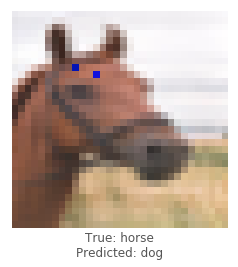

In [23]:
_ = attack_targeted_iteration(99, wide_resnet, 5, pixel_count=2, callback=targeted_callback)

In [28]:
def attack_targeted(model, pixel_count=1, sample_count=100, iterations=30,
                      population=10, mutation=0.5, recombination=1, 
                      stop_threshold=-0.01, callback=targeted_callback):
    samples = np.random.choice(len(x_test), sample_count)
    
    results = []
    for i,img in enumerate(samples):
        print('Sample', i)
        for target in range(10):
            if target == y_test[img]:
                continue
            result = attack_targeted_iteration(
                img, model, target, pixel_count, iterations,
                population, mutation, recombination, 
                stop_threshold, callback)
            results.append(result)
            print()
            
    return pd.DataFrame(
        data=results,
        columns=['image_index', 'true_class', 'predicted_class', 'success', 'predicted_probs', 'attack_image']
    )

Sample 0
Attacking image 3297 with target 0 airplane
Confidence: 0.00030981805
Confidence: 0.00030981805
Confidence: 0.00030981805
Confidence: 0.00039476992
Confidence: 0.00039476992
Confidence: 0.0005574349
Confidence: 0.0005753273
Confidence: 0.0022128075
Confidence: 0.004434155
Confidence: 0.0056852084
Confidence: 0.0059388955
Confidence: 0.0059388955
Confidence: 0.006191492
Confidence: 0.007434649
Confidence: 0.007990558
Confidence: 0.007997345
Confidence: 0.007997345
Confidence: 0.007997345
Confidence: 0.007997345
Confidence: 0.008075765
Confidence: 0.008326848
Confidence: 0.008326848
Confidence: 0.008326848
Confidence: 0.008326848
Confidence: 0.008326848
Confidence: 0.008326848
Confidence: 0.008326848
Confidence: 0.008326848
Confidence: 0.008326848
Confidence: 0.008326848


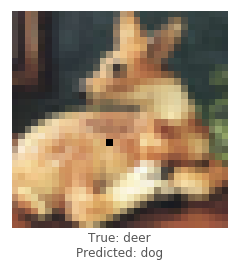


Attacking image 3297 with target 1 automobile
Confidence: 0.002136918
Confidence: 0.002136918
Confidence: 0.002136918
Confidence: 0.002563536
Confidence: 0.0029901536
Confidence: 0.0031027335
Confidence: 0.0031174864
Confidence: 0.0034438006
Confidence: 0.003455465
Confidence: 0.003456479
Confidence: 0.0034574706
Confidence: 0.0034591036
Confidence: 0.003459241
Confidence: 0.003459241
Confidence: 0.003459241
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313


/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313
Confidence: 0.003459313


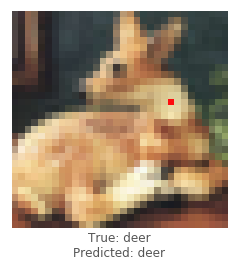


Attacking image 3297 with target 2 bird
Confidence: 0.0009113776
Confidence: 0.0009113776
Confidence: 0.0009159393
Confidence: 0.0011878983
Confidence: 0.0012988477
Confidence: 0.0012988477
Confidence: 0.0012988477
Confidence: 0.0013013493
Confidence: 0.0013028418
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915
Confidence: 0.001302915


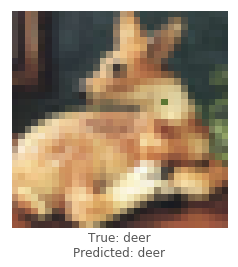


Attacking image 3297 with target 3 cat
Confidence: 0.4482249
Confidence: 0.50755817


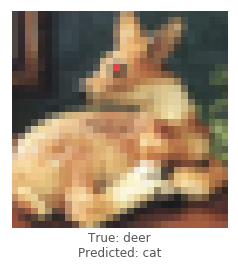


Attacking image 3297 with target 5 dog
Confidence: 0.9816688


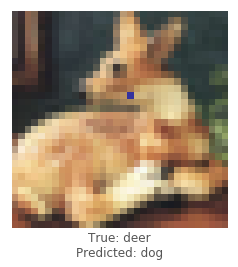


Attacking image 3297 with target 6 frog
Confidence: 0.08025762
Confidence: 0.08025762
Confidence: 0.0941122
Confidence: 0.0941122
Confidence: 0.0941122
Confidence: 0.1401928
Confidence: 0.1401928
Confidence: 0.1401928
Confidence: 0.14319046
Confidence: 0.14525524
Confidence: 0.14525524
Confidence: 0.14609945
Confidence: 0.14685218
Confidence: 0.1474388
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194
Confidence: 0.14769194


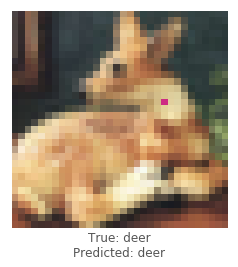


Attacking image 3297 with target 7 horse
Confidence: 0.033488158
Confidence: 0.042102676
Confidence: 0.09185223
Confidence: 0.09185223
Confidence: 0.092719585
Confidence: 0.092719585
Confidence: 0.092719585
Confidence: 0.092719585
Confidence: 0.09456644
Confidence: 0.09499813
Confidence: 0.09647471
Confidence: 0.09647471
Confidence: 0.09679911
Confidence: 0.09679911
Confidence: 0.09682592
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781
Confidence: 0.09682781


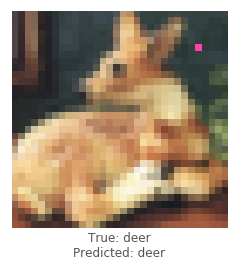


Attacking image 3297 with target 8 ship
Confidence: 0.0009564901
Confidence: 0.0009564901
Confidence: 0.0010501115
Confidence: 0.0012912536
Confidence: 0.0013428708
Confidence: 0.001345041
Confidence: 0.0013469023
Confidence: 0.0013508741
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345
Confidence: 0.0013509345


KeyboardInterrupt: 

In [29]:
targeted_results = attack_targeted(resnet)

In [ ]:
targeted_results

### Show some successful attacks

Plot the first 9 misclassified images

## Credits
 - Base code taken from https://github.com/09rohanchopra/cifar10
 - https://arxiv.org/pdf/1412.6806.pdf
 - https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
 - https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
 - http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
 - https://parneetk.github.io/blog/cnn-cifar10/
 - https://github.com/dnlcrl/deep-residual-networks-pyfunt/blob/master/docs/CIFAR-10%20Experiments.ipynb